# Inference Demo for Resnet-50 FP32/INT8 Models (With ONNXRuntime)

## Overview

This notebook shows how to use the trained models to do inference in ONNXRuntime. Please install the prerequisite packages if not already installed.

## Prerequisites

* Protobuf compiler - `sudo apt-get install protobuf-compiler libprotoc-dev` (required for ONNX. This will work for any linux system. For detailed installation guidelines head over to [ONNX documentation](https://github.com/onnx/onnx#installation))
* ONNX - `pip install onnx`
* ONNXRuntime - `pip install onnxruntime`
* matplotlib - `pip install matplotlib`
* PIL - `pip install Pillow`
* numpy - `pip install numpy`
* cv2 - `pip install opencv-python`

In order to do inference with a python script: 
* Generate the script : In Jupyter Notebook browser, go to File -> Download as -> Python (.py)
* Run the script: `python onnxrt_inference.py`

### Import dependencies

Verify that all dependencies are installed using the cell below. Continue if no errors encountered, warnings can be ignored.

In [4]:
import onnx
import numpy as np
import onnxruntime as ort
from PIL import Image
import cv2
import matplotlib.pyplot as plt

### Prepare image and label file

Download image: 
`wget 'https://s3.amazonaws.com/model-server/inputs/kitten.jpg'`

Download label file:
`wget 'https://s3.amazonaws.com/onnx-model-zoo/synset.txt'`

In [2]:
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

FileNotFoundError: [Errno 2] No such file or directory: 'synset.txt'

### Import ONNX model

Import an onnx model

In [8]:
model_path = r'D:\algorithm\deeplearning\Semantic Segmentation\segment-anything-main\notebooks\resnet18.onnx'
model = onnx.load(model_path)
# Start from ORT 1.10, ORT requires explicitly setting the providers parameter if you want to use execution providers
# other than the default CPU provider (as opposed to the previous behavior of providers getting set/registered by default
# based on the build flags) when instantiating InferenceSession.
# For example, if NVIDIA GPU is available and ORT Python package is built with CUDA, then call API as following:
# onnxruntime.InferenceSession(path/to/model, providers=['CUDAExecutionProvider']).
session = ort.InferenceSession(model.SerializeToString())

### Read image

`get_image(path, show=False)` : Read and show the image taking the `path` as input

In [9]:
def get_image(path, show=False):
    with Image.open(path) as img:
        img = np.array(img.convert('RGB'))
    if show:
        plt.imshow(img)
        plt.axis('off')
    return img

### Preprocess image

`preprocess(img)` : Preprocess inference image -> scale to 0~1, resize to 256x256, take center crop of 224x224, normalize image, transpose to NCHW format, cast to float32 and add a dimension to batchify the image

In [10]:
def preprocess(img):
    img = img / 255.
    img = cv2.resize(img, (224, 224))
    #img = cv2.resize(img, (256, 256))
    # h, w = img.shape[0], img.shape[1]
    # y0 = (h - 224) // 2
    # x0 = (w - 224) // 2
    # img = img[y0 : y0+224, x0 : x0+224, :]
    # img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    img = np.transpose(img, axes=[2, 0, 1])
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

### Predict

`predict(path)` : Takes `path` of the input image and flag to display input image and prints 1 top predictions


In [11]:
def predict(path):
    img = get_image(path, show=True)
    img = preprocess(img)
    ort_inputs = {session.get_inputs()[0].name: img}
    preds = session.run(None, ort_inputs)[0]
    preds = np.squeeze(preds)
    print(preds[:10])
    a = np.argsort(preds)[::-1]
    print('class=%s ; probability=%f' %(a[0],preds[a[0]]))

### Generate predictions

The top 1 class along with the probabilities generated for the image is displayed in the output of the cell below


[-1.0555942  -0.71504736 -2.987355   -0.39725748 -2.2203722   0.5124588
 -3.2889788  -2.3336935  -1.7871635  -3.1933155 ]
class=285 ; probability=11.529849


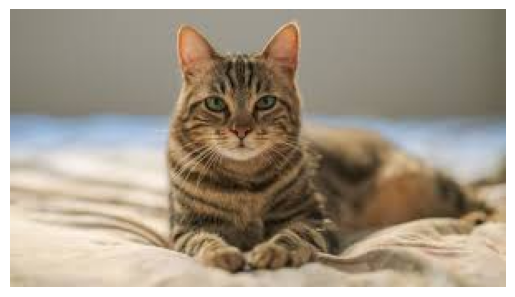

In [12]:
# Enter path to the inference image below
img_path = './images/cat.jpg'
predict(img_path)